# Implementation of ANN:

## Initializing the ANN for a given architecture:

- $W$ and $b$ are the wights and biases for each layer respectively.
- $Z$ are the input into each neuron before activation.
- $A$ are the output of each neuron after activation 

Initialization:

- ANN_architecture is a dictionary containing the number of neurons in each layer and their activation functions.
- $W_l$ is initialized randomly to a size of $n_{l+1} \times n_l$.
- $b_l$ is initialized as zero of size $n_{l+1} \times 1$.

In [1]:
# Importing required libraries.  

import numpy as np
from numpy import random
import matplotlib.pyplot as plt

In [2]:
# Initialization.

def init_ANN(ANN_architecture, seed = 99):
    np.random.seed(seed)

    # Initialize parameters.
    parameters = {}

    for idx, layer in enumerate(ANN_architecture):
        layer_idx = idx+1
        
        input_layer_size = layer['inputs']
        output_layer_size = layer['outputs']

        parameters['W' + str(layer_idx)] = random.randn(output_layer_size, input_layer_size)
        parameters['b' + str(layer_idx)] = np.zeros((output_layer_size, 1))
    
    return parameters

# Error function. (Mean Squared Error)

def error_fn(Y_hat, Y):
    N = Y_hat.shape[1]
    return np.squeeze((1/(2*N))*np.dot((Y_hat - Y), (Y_hat - Y).T))



## Forward Propagation:

- $Z_l = W_{(l,l-1)}A_{l-1} + b_{l-1}$ 
- $A_l = sigmoid(Z_l)$

In [3]:
# Activation functions.

def linear(Z):
    A = Z
    return A

def RelU(Z):
    A = Z
    A[A < 0] = 0
    return A

def sigmoid(Z):
    A = 1/(1 + np.exp(-Z))
    return A

def activation_fn(Z, activation):
    if activation == 'linear':
        return linear(Z)
    elif activation == 'sigmoid':
        return sigmoid(Z)
    elif activation == 'ReLU':
        return RelU(Z)
    else:
        print('Activation function not recognized.')


# Derivatives of activation functions.

def lin_der(Z, dA): # dZ = dA*(derivative of activation function at Z)
    dZ = dA
    return dZ

def ReLU_der(Z, dA): # dZ = dA*(derivative of activation function at Z)
    dZ = dA
    dZ[dZ < 0] = 0
    return dZ

def sig_der(Z, dA): # dZ = dA*(derivative of activation function at Z)
    der_sig_at_Z = sigmoid(Z)*(1 - sigmoid(Z))
    dZ = dA*(der_sig_at_Z)
    return dZ

def activation_fn_backprop(Z, dA, activation):
    if activation == 'linear':
        return lin_der(Z, dA)
    elif activation == 'sigmoid':
        return sig_der(Z, dA)
    elif activation == 'ReLU':
        return ReLU_der(Z, dA)
    else:
        print('Activation function not recognized.')
    

In [4]:
# Feed-forward function. (Single layer)

def feed_forward(A_prev, W_curr, b_curr, activation):
    Z_curr = np.dot(W_curr, A_prev) + b_curr
    A_curr = activation_fn(Z_curr, activation)
    return (Z_curr, A_curr)

# Forward propagation function. (Multi layered)

def forward_prop(X, Y, parameters, ANN_architecture):
    # Initializing cache and A_prev. 
    cache = {}
    A_curr = X


    # Run forward propagation over all layers.
    for idx, layer in enumerate(ANN_architecture):
        layer_idx = idx+1
        A_prev = A_curr
        W_curr = parameters['W' + str(layer_idx)]
        b_curr = parameters['b' + str(layer_idx)]
        activation = layer['activation']

        Z_curr, A_curr = feed_forward(A_prev, W_curr, b_curr, activation) 

        cache['A' + str(idx)] = A_prev
        cache['Z' + str(layer_idx)] = Z_curr
    
    error = error_fn(A_curr, Y)

    return (error, cache, A_curr)

## Backward Propagation:

- Given $W$, $b$, $\hat{Y}$, $Y$ (expected output) and $X$, we find $\frac{\partial E}{\partial W_{i_l, j_{l-1}}}$ and $\frac{\partial E}{\partial b_{i_l}}$, where $E$ is the "$\textit{mean squared error}$".
- From gradient descent, $\Delta W_{i_l, j_{l-1}} = -\eta*\frac{\partial E}{\partial W_{i_l, j_{l-1}}}$ and $\Delta b_{i_l} = -\eta*\frac{\partial E}{\partial b_{i_l}}$, where $\eta$ is the "$\textit{learning rate}$". $\eta$ is a hyperparameter of our choice.
- Let $\delta_{i_l} = \frac{\partial E}{\partial Z_{i_l}}$. 

Here:
- $\delta_{L} = \frac{\partial E}{\partial A_{L}} = y-\hat{y}$
- $\frac{\partial E}{\partial W_{i_l, j_{l-1}}} =  \frac{\partial E}{\partial A_{i_l}}\frac{\partial A_{i_l}}{\partial Z_{i_l}}\frac{\partial Z_{i_l}}{\partial W_{i_l, j_{l-1}}} = \delta_{i_l}\sigma'(Z_{i_l})A_{j_{l-1}}$.
- $\frac{\partial E}{\partial b_{i_l}} = \frac{1}{N}\sum_{i_{l} = 1}^{n_{l}}Z_{i_l}$
- $\Delta W_{i_l, j_{l-1}} = -\eta\delta_{i_l}\sigma'(Z_{i_l})A_{j_{l-1}}$.
- $\Delta b_{i_l} = -\eta\frac{1}{N}\sum_{i_{l} = 1}^{n_{l}}A_{i_l}$
- $\delta_{j_{l}} = \sum_{i_{l+1} = 1}^{n_{l+1}}W_{i_{l+1}, j_{l}}\sigma'(Z_{i_{l+1}})A_{j_{l-1}}$, for hidden layers.

In [5]:
# Backprop function. (Single layer)

def back_prop_single(dA_curr, Z_curr, A_prev, W_curr, activation): # delta = dE/dZ_next
     # Normalization.
     N = A_prev.shape[1]

     # dA = dE/dA, dZ = dE/dZ, dW = dE/dW, db = dE/db.
     dZ_curr = activation_fn_backprop(Z_curr, dA_curr, activation)
     
     dW_curr = np.dot(dZ_curr, A_prev.T)/N # dE/dW = dE/dX*dX/dW
     db_curr = np.sum(dZ_curr, axis = 1, keepdims = True)/N #dE/db = dE/dX*dX/db
     dA_prev = np.dot(W_curr.T, dZ_curr) # dE/dZ_prev = delta_prev

     return dW_curr, db_curr, dA_prev

# Backprop function. (Multiple layered.
def back_prop(Y_hat, Y, parameters, cache, ANN_architecture):
     #Initialize gradients and dA_prev.
     gradients = {}
     dA_prev = Y_hat - Y
     
     for layer_idx_prev, layer in reversed(list(enumerate(ANN_architecture))):
          layer_idx_curr = layer_idx_prev+1
          dA_curr = dA_prev

          Z_curr = cache['Z' + str(layer_idx_curr)]
          A_prev = cache['A' + str(layer_idx_prev)]
          W_curr = parameters['W' + str(layer_idx_curr)]
          activation_curr = layer['activation']

          dW_curr, db_curr, dA_prev = back_prop_single(dA_curr, Z_curr, A_prev, W_curr, activation_curr)

          gradients['dW' + str(layer_idx_curr)] = dW_curr
          gradients['db' + str(layer_idx_curr)] = db_curr
     
     return gradients


In [6]:
# Weight Update function.

def update(ANN_architecture, parameters, gradients, eta):
    # Update parameters.
    for layer_idx, _ in enumerate(ANN_architecture, 1):
        parameters['W' + str(layer_idx)] -= eta * gradients['dW' + str(layer_idx)]        
        parameters['b' + str(layer_idx)] -= eta * gradients['db' + str(layer_idx)]
    
    return parameters

## Weight Perturbation:

- we perturb weight weight $W_{i_l, j_{l-1}}$ by $pert_{i_l, j_{l-1}}$. 
- Next we find $y$ using forward propagation. Then, we find $\frac{\partial E}{\partial W_{i_l, j_{l-1}}} = \frac{E(W_{i_l, j_{l-1}} + pert_{i_l, j_{l-1}}) - E(W_{i_l, j_{l-1}})}{pert_{i_l, j_{l-1}}}$.
- Next, $\Delta W_{i_l, j_{l-1}} = -\eta*\frac{\partial E}{\partial W_{i_l, j_{l-1}}}$, as calculated above.
- We repeat the above process for all $W_{i_l, j_{l-1}}$ while the error is greater than the convergence criteria. (0.01 in our case).

In [7]:
# Weight Perterbation function. (One round of perturbation)

def weight_pert(parameters, X, Y, E, pert, ANN_architecture): # pert is the perterbation strength. conv is the convergence criteria
    # Initialize gradients and perturbed parameters.
    gradients = {}
    parameters_pert = parameters
    for layer_idx, layer in enumerate(ANN_architecture, 1):
        gradients['dW' + str(layer_idx)] = np.zeros(parameters['W' + str(layer_idx)].shape)
        gradients['db' + str(layer_idx)] = np.zeros(parameters['b' + str(layer_idx)].shape)

    # Run weight perturbation.
    for layer_idx, layer in enumerate(ANN_architecture, 1):
        for weight_idx, _ in np.ndenumerate(parameters['W' + str(layer_idx)]):
            E_pert = 0
            parameters_pert['W' + str(layer_idx)][weight_idx] += pert
            E_pert, _, _ = forward_prop(X, Y, parameters_pert, ANN_architecture)
            del_E = E_pert - E
            gradients['dW' + str(layer_idx)][weight_idx] = del_E/pert
            #print(gradients['dW' + str(layer_idx)][weight_idx])
        for bias_idx, _ in np.ndenumerate(parameters['b' + str(layer_idx)]):
            parameters_pert['b' + str(layer_idx)][bias_idx] += pert
            E_pert, _, _ = forward_prop(X, Y, parameters_pert, ANN_architecture)
            del_E = E_pert - E
            gradients['db' + str(layer_idx)][bias_idx] = del_E/pert


    return gradients


## Training the ANN:
 
We define a train function which takes in the ANN_architecture, X, $\hat{Y}$, epochs and eta and returns the output after training and the error after each epoch.

In [8]:
# Training using backprop.
 
def train_backprop(ANN_architecture, X, Y, epochs, eta):
    # Initialize weights and errors.
    parameters = init_ANN(ANN_architecture, 1)
    errors = []

    # Train.
    for ep in range(epochs):
        error, cache, Y_hat = forward_prop(X, Y, parameters, ANN_architecture)
        errors.append(error)

        gradients = back_prop(Y_hat, Y, parameters, cache, ANN_architecture)
        parameters = update(ANN_architecture, parameters, gradients, eta)

    return parameters, np.asarray(errors)

# Training using weight perturbation.

def train_pert(ANN_architecture, X, Y, epochs, pert, eta):
    # Initialize weights and errors.
    parameters = init_ANN(ANN_architecture, 1)
    errors = []

    # Train.
    for ep in range(epochs):
        error, cache, Y_hat = forward_prop(X, Y, parameters, ANN_architecture)
        errors.append(error)

        gradients = weight_pert(parameters, X, Y, error, pert, ANN_architecture)
        parameters = update(ANN_architecture, parameters, gradients, eta)

    return parameters, np.asarray(errors)

# Testing.

def test(X, Y, parameters, ANN_architecture):
    error, _, Y = forward_prop(X, Y, parameters, ANN_architecture)
    Y[Y > 0.5] = 1
    Y[Y <= 0.5] = 0
    return Y, error

## Feed-forward XOR network:

In [9]:
# Feed-forward XOR. (Main 1)

ANN_architecture = [{'inputs':2, 'outputs':2, 'activation':'sigmoid'}, {'inputs':2, 'outputs':1, 'activation':'linear'}]
X = np.array([[0, 0, 1, 1], [0, 1, 0, 1]]) 
Y = np.array([[0, 1, 1, 0]])

[[1. 0. 0. 1.]]
[[1. 0. 0. 1.]]


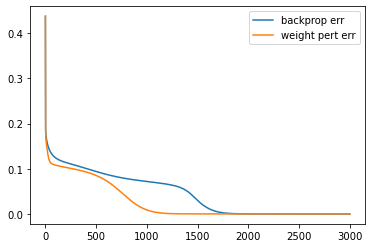

In [10]:
parameters_bp, errors_bp = train_backprop(ANN_architecture, X, Y, 3000, 0.3)
Y_bp, E_bp = test(np.array([[1, 1, 0, 0], [0, 1, 0, 1]]), np.array([[1, 0, 0, 1]]), parameters_bp, ANN_architecture)
plt.plot(range(3000), errors_bp)
print(Y_bp)
parameters_pert, errors_pert = train_pert(ANN_architecture, X, Y, 3000, 0.0001, 0.3)
Y_pert, E_pert = test(np.array([[1, 1, 0, 0], [0, 1, 0, 1]]), np.array([[1, 0, 0, 1]]), parameters_pert, ANN_architecture)
print(Y_bp)
plt.plot(range(3000), errors_pert)
plt.legend(['backprop err', 'weight pert err'])